<a href="https://colab.research.google.com/github/Bilpapster/Neural-Networks/blob/main/1a_KNN_and_Nearest_Centroid_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate assignment in Neural Networks - Deep Learning

> Vasileios Papastergios (ID: 3651)


---


# Introduction

The current Jupiter Notebook contains python source code for the first intermediate assignment in the course of [Neural Networks - Deep Learing](https://qa.auth.gr/en/x/class/1/600237255). The author attended the course during their 7th semester of studies at the [Aristotle University of Thessaloniki (AUTH)](https://www.csd.auth.gr/en/).

The first intermediate assignment focuses on selecting a dataset and implementing basic non-neural-networks classifying techniques for multiclass classification.We have selected to work with the [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data) dataset, which was found on [Kaggle](https://www.kaggle.com/datasets). The dataset consists of a train set (14K images) and a test set (3K images) of images that belong to one of the 6 mutually exclusive following classes:
1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street

We use the training set to train three classification models, so as to compute and compare their performance. In particular, we investigate the performance of the following three models:
- a K-nearest neighbors classifier, for K=1 neighbor
- a K-nearest neighbors classifier, for K=3 neighbors
- a nearest centroid classifier

Below, we present the series of steps we have taken throughout our investigation, starting from the preliminary ones towards the core steps of training the classifiers and measuring their performance.


# A. Preliminary steps

Before diving into the "actual" tasks of the assignment, we need to take some preliminary steps.

## A.1. Necessary imports

At first, we import a few libraries that we are going to use later on this assignment. Furthermore, we mount the Google Drive storage. This enables us to download and store the Kaggle dataset in our Google Drive and handle it conveniently.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## A.2. Downloading the dataset

In the following cell we configure the environment and download the [Intel Image classification dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data) into our Google Drive. The dataset is downloaded as a .zip file, so we need to unzip it and then remove the .zip file that is no longer needed.

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/gdrive/My Drive/Kaggle"
%cd /gdrive/My Drive/Kaggle
%pwd
!kaggle datasets download -d puneet6060/intel-image-classification
%ls
!unzip /*.zip && !rm /*.zip

Mounted at /gdrive


## A.3. Creating a train.csv file

Taking a closer look into the extracted directories, we can easily find out that the path /gdrive/My Drive/Kaggle/seg_train/seg_train/ contains the training set images. In particular there are 6 sub-directories inside that path, one for every class of the multiclass classification problem with respective names:

1. buildings
2. forest
3. glacier
4. mountain
5. sea
6. street

We would like to use this observation in order to create a .csv file that contains the full path for every training image, as well as the class label and the class number of it, all in one place. The following cells do that exact actions.



In [3]:
def get_file_list(directory):
  '''
  a utility function that gets a directory and recursively explores it
  returns a 2D array, containing records in the form [path, parent_directory_name]
  '''
  file_list = os.listdir(directory)
  all_files = []
  for entry in file_list:
    path = os.path.join(directory, entry)
    parent_directory = path.split('/')[-2]
    if os.path.isdir(path):
      all_files = all_files + get_file_list(path)
    else:
      all_files.append([path, parent_directory])
  return all_files

In [ ]:
# we use the utility function to get the full list of traning image paths,
# combined with the parent directory (class) name
# we print the first 5 records for better understanding

path = '/gdrive/My Drive/Kaggle/seg_train/seg_train/'
all_files_list = get_file_list(path)
print(np.shape(all_files_list))
all_files_list[0:5]

(14034, 2)


[['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19638.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/1954.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19537.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19440.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19460.jpg',
  'buildings']]

(150, 150, 3)


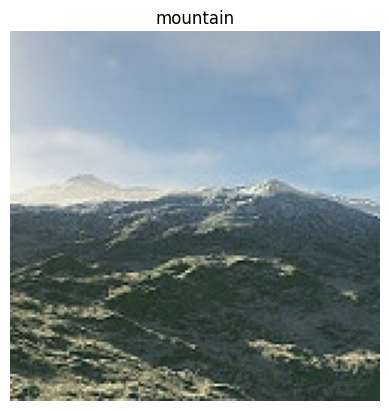

In [ ]:
import random

random_index = random.randint(0, len(all_files_list) - 1)

image_path = all_files_list[random_index][0]
label = all_files_list[random_index][1]
image_array = plt.imread(image_path)
print(image_array.shape)
plt.imshow(image_array)
plt.axis('off')
plt.title(label)
plt.show()

In [ ]:
train_data = pd.DataFrame(data = all_files_list, columns=['filepath', 'label_verbose'])
pd.set_option('display.max_colwidth', None)
train_data.head()

,filepath,label_verbose
0,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19638.jpg,buildings
1,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/1954.jpg,buildings
2,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19537.jpg,buildings
3,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19440.jpg,buildings
4,/gdrive/My Drive/Kaggle/seg_train/seg_train/buildings/19460.jpg,buildings


In [ ]:
labels_list = [
    "buildings",
    "forest",
    "glacier",
    "mountain",
    "sea",
    "street"
]

labels_dict = {label:index for index, label in enumerate(labels_list)}

train_data['label'] = train_data['label_verbose'].map(labels_dict)

train_data.to_csv('/gdrive/My Drive/Kaggle/train.csv',index=False)

NameError: ignored

----- visualizing the data

In [ ]:
labels_list = [
    "buildings",
    "forest",
    "glacier",
    "mountain",
    "sea",
    "street"
]

labels_dict = {label:index for index, label in enumerate(labels_list)}

train_data = pd.read_csv('/gdrive/My Drive/Kaggle/train.csv')
train_data = train_data.sample(frac=1., random_state=22)
train_data.head(10)

,filepath,label_verbose,label
6277,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
12623,/gdrive/My Drive/Kaggle/seg_train/seg_train/st...,street,5
4314,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1
4711,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
10549,/gdrive/My Drive/Kaggle/seg_train/seg_train/se...,sea,4
5169,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
5595,/gdrive/My Drive/Kaggle/seg_train/seg_train/gl...,glacier,2
3054,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1
3468,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1
2246,/gdrive/My Drive/Kaggle/seg_train/seg_train/fo...,forest,1


(150, 150, 3)


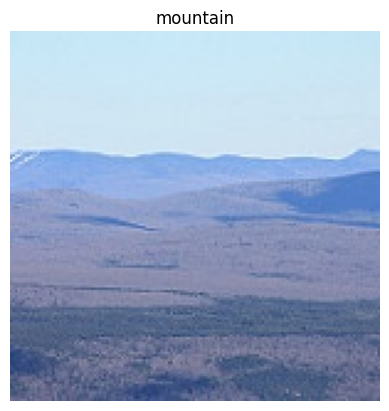

In [ ]:
import random

random_index = random.randint(0, len(train_data['filepath']) - 1)

image_path = train_data['filepath'][random_index]
label = train_data['label_verbose'][random_index]
image_array = plt.imread(image_path)
print(image_array.shape)
plt.imshow(image_array)
plt.axis('off')
plt.title(label)
plt.show()

In [ ]:
classes_frequency_dict = {label: 0 for label in labels_list}
image_shapes_frequency_dict = {}

for row in range(len(train_data)):
  print(str(row))
  label_verbose = train_data['label_verbose'][row]
  classes_frequency_dict[label_verbose] += 1

  image_array = plt.imread(train_data['filepath'][row])
  image_shape_string = str(image_array.shape)
  image_shapes_frequency_dict[image_shape_string] = 1 if image_shape_string not in image_shapes_frequency_dict else image_shapes_frequency_dict[image_shape_string] + 1

print(classes_frequency_dict)
print(image_shapes_frequency_dict)

{'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}
{'(150, 150, 3)': 13986, '(124, 150, 3)': 1, '(136, 150, 3)': 2, '(108, 150, 3)': 2, '(113, 150, 3)': 7, '(133, 150, 3)': 1, '(115, 150, 3)': 1, '(135, 150, 3)': 3, '(76, 150, 3)': 1, '(97, 150, 3)': 1, '(111, 150, 3)': 3, '(120, 150, 3)': 1, '(149, 150, 3)': 1, '(143, 150, 3)': 2, '(146, 150, 3)': 2, '(134, 150, 3)': 2, '(123, 150, 3)': 2, '(142, 150, 3)': 2, '(119, 150, 3)': 1, '(102, 150, 3)': 1, '(110, 150, 3)': 1, '(105, 150, 3)': 1, '(100, 150, 3)': 1, '(141, 150, 3)': 1, '(145, 150, 3)': 1, '(81, 150, 3)': 1, '(147, 150, 3)': 1, '(131, 150, 3)': 1, '(144, 150, 3)': 2, '(103, 150, 3)': 1, '(140, 150, 3)': 1}


In [ ]:
import pickle

with open("/gdrive/My Drive/Kaggle/classes_frequency_dict.pkl", "wb") as outfile:
  pickle.dump(classes_frequency_dict, outfile)

with open("/gdrive/My Drive/Kaggle/image_shapes_frequency_dict.pkl", "wb") as outfile:
  pickle.dump(image_shapes_frequency_dict, outfile)

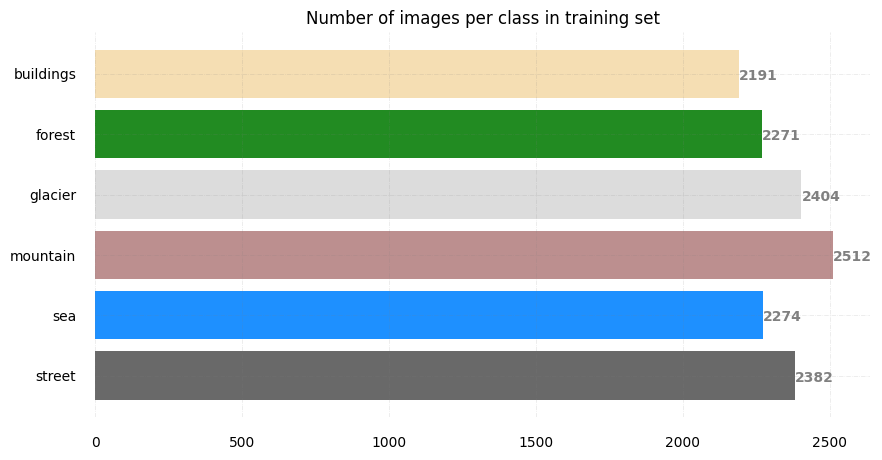

In [ ]:
import pickle

with open("/gdrive/My Drive/Kaggle/classes_frequency_dict.pkl", "rb") as infile:
  classes_frequency_dict = pickle.load(infile)

fig, ax = plt.subplots(figsize=(10, 5))

colors_dict = {
    'street': 'dimgray',
    'sea': 'dodgerblue',
    'forest': 'forestgreen',
    'glacier': 'gainsboro',
    'mountain': 'rosybrown',
    'buildings': 'wheat'
}

labels_list = list(classes_frequency_dict.keys())
labels_frequency_list = list(classes_frequency_dict.values())
plt.barh(labels_list, labels_frequency_list, color=[colors_dict[label] for label in labels_list])
plt.title('Number of images per class in training set')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 10)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

for spline in ['top', 'left', 'right', 'bottom']:
    ax.spines[spline].set_visible(False)

for patch in ax.patches:
    plt.text(patch.get_width()+0.2, patch.get_y()+0.5,
                   str(round((patch.get_width()), 2)),
                   fontsize = 10, fontweight ='bold',
                   color ='grey')
plt.savefig(f'/gdrive/My Drive/Kaggle/plots/bar plots/bar_plot_classes.png', transparent=True)

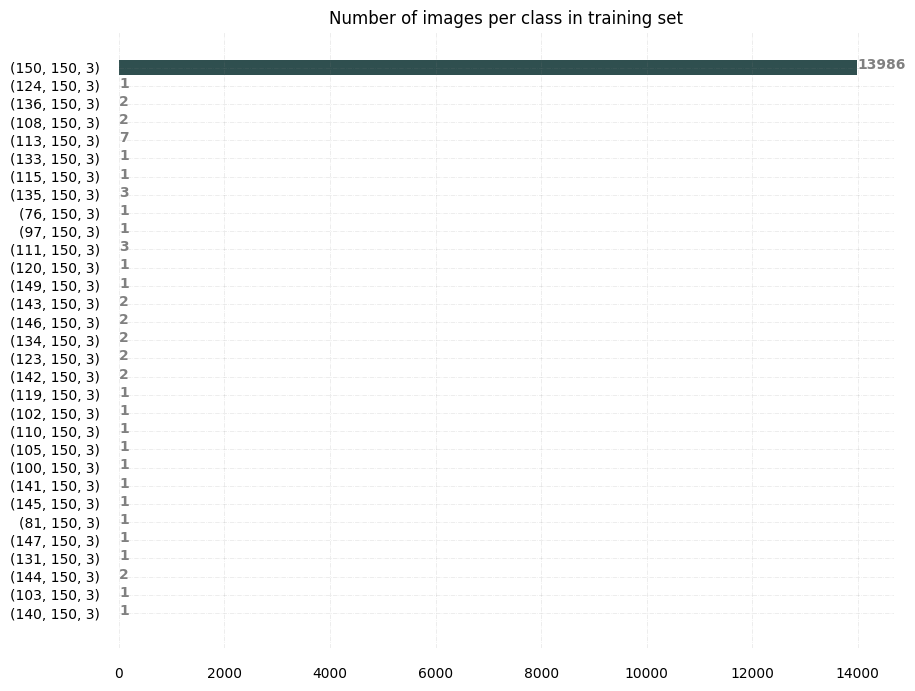

In [ ]:
import pickle

with open("/gdrive/My Drive/Kaggle/image_shapes_frequency_dict.pkl", "rb") as infile:
  image_shapes_frequency_dict = pickle.load(infile)

fig, ax = plt.subplots(figsize=(10, 8))

shapes_list = list(image_shapes_frequency_dict.keys())
shapes_frequency_list = list(image_shapes_frequency_dict.values())
plt.barh(shapes_list, shapes_frequency_list, color='darkslategrey')
plt.title('Number of images per class in training set')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 10)

ax.yaxis.set_ticks_position('none')
ax.yaxis.set_tick_params(pad = 10)

ax.invert_yaxis()
ax.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)

for spline in ['top', 'left', 'right', 'bottom']:
    ax.spines[spline].set_visible(False)

for patch in ax.patches:
    plt.text(patch.get_width()+0.2, patch.get_y()+0.5,
                   str(round((patch.get_width()), 2)),
                   fontsize = 10, fontweight ='bold',
                   color ='grey')
plt.savefig('/gdrive/My Drive/Kaggle/plots/bar plots/bar_plot_shapes.png', transparent=True)

In [ ]:
X_train = []
y_train = []
desired_shape = (150, 150, 3)
nof_training_samples = len(train_data)

for row in range(nof_training_samples):
  image_array = np.array(plt.imread(train_data['filepath'][row]))
  image_shape = np.shape(image_array)
  if image_shape[0] != desired_shape[0]:
    label= train_data['label'][row]
    print(f'found anomaly in line {str(row)} of class {labels_list[label]}')
    continue
  flattened_image_array = np.reshape(a=image_array, newshape=desired_shape[0] * desired_shape[1] * desired_shape[2])
  X_train.append(flattened_image_array)
  y_train.append(train_data['label'][row])

print(np.shape(X_train))
print(np.shape(y_train))



found anomaly in line 424 of class buildings
found anomaly in line 2616 of class forest
found anomaly in line 2654 of class forest
found anomaly in line 2813 of class forest
found anomaly in line 3206 of class forest
found anomaly in line 3483 of class forest
found anomaly in line 3502 of class forest
found anomaly in line 3681 of class forest
found anomaly in line 4201 of class forest
found anomaly in line 4506 of class glacier
found anomaly in line 4526 of class glacier
found anomaly in line 4832 of class glacier
found anomaly in line 5112 of class glacier
found anomaly in line 5135 of class glacier
found anomaly in line 5474 of class glacier
found anomaly in line 5757 of class glacier
found anomaly in line 5931 of class glacier
found anomaly in line 5991 of class glacier
found anomaly in line 6072 of class glacier
found anomaly in line 6078 of class glacier
found anomaly in line 6090 of class glacier
found anomaly in line 6104 of class glacier
found anomaly in line 6163 of class gla

In [ ]:
path = '/gdrive/My Drive/Kaggle/seg_test/seg_test/'
all_files_list = get_file_list(path)
print(np.shape(all_files_list))
all_files_list[0:5]

(3000, 2)


[['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20140.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20177.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20064.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20186.jpg',
  'buildings'],
 ['/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20083.jpg',
  'buildings']]

(150, 150, 3)


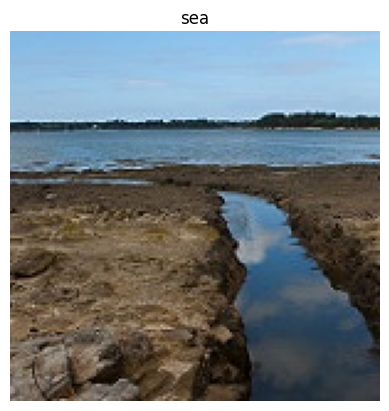

In [ ]:
import random

random_index = random.randint(0, len(all_files_list) - 1)

image_path = all_files_list[random_index][0]
label = all_files_list[random_index][1]
image_array = plt.imread(image_path)
print(image_array.shape)
plt.imshow(image_array)
plt.axis('off')
plt.title(label)
plt.show()

In [ ]:
test_data = pd.DataFrame(data = all_files_list, columns=['filepath', 'label_verbose'])
pd.set_option('display.max_colwidth', None)
test_data.head()

,filepath,label_verbose
0,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20140.jpg,buildings
1,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20177.jpg,buildings
2,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20064.jpg,buildings
3,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20186.jpg,buildings
4,/gdrive/My Drive/Kaggle/seg_test/seg_test/buildings/20083.jpg,buildings


In [ ]:
test_data['label'] = test_data['label_verbose'].map(labels_dict)

test_data.to_csv('/gdrive/My Drive/Kaggle/test.csv',index=False)

NameError: ignored

In [ ]:
labels_list = [
    "buildings",
    "forest",
    "glacier",
    "mountain",
    "sea",
    "street"
]

test_data = pd.read_csv('/gdrive/My Drive/Kaggle/test.csv')
test_data = test_data.sample(frac=1., random_state=22)
test_data.head(10)

,filepath,label_verbose,label
1198,/gdrive/My Drive/Kaggle/seg_test/seg_test/glac...,glacier,2
1800,/gdrive/My Drive/Kaggle/seg_test/seg_test/moun...,mountain,3
2196,/gdrive/My Drive/Kaggle/seg_test/seg_test/sea/...,sea,4
2462,/gdrive/My Drive/Kaggle/seg_test/seg_test/sea/...,sea,4
1699,/gdrive/My Drive/Kaggle/seg_test/seg_test/moun...,mountain,3
2143,/gdrive/My Drive/Kaggle/seg_test/seg_test/sea/...,sea,4
570,/gdrive/My Drive/Kaggle/seg_test/seg_test/fore...,forest,1
1400,/gdrive/My Drive/Kaggle/seg_test/seg_test/glac...,glacier,2
1230,/gdrive/My Drive/Kaggle/seg_test/seg_test/glac...,glacier,2
246,/gdrive/My Drive/Kaggle/seg_test/seg_test/buil...,buildings,0


In [ ]:
X_test = []
y_test = []
desired_shape = (150, 150, 3)
nof_testing_samples = len(test_data)

for row in range(nof_testing_samples):
  image_array = np.array(plt.imread(test_data['filepath'][row]))
  image_shape = np.shape(image_array)
  if image_shape[0] != desired_shape[0]:
    label= test_data['label'][row]
    print(f'found anomaly in line {str(row)} of class {labels_list[label]}')
    continue
  flattened_image_array = np.reshape(a=image_array, newshape=desired_shape[0] * desired_shape[1] * desired_shape[2])
  X_test.append(flattened_image_array)
  y_test.append(test_data['label'][row])

print(np.shape(X_test))
print(np.shape(y_test))

found anomaly in line 641 of class forest
found anomaly in line 1085 of class glacier
found anomaly in line 1098 of class glacier
found anomaly in line 1128 of class glacier
found anomaly in line 1290 of class glacier
found anomaly in line 1713 of class mountain
found anomaly in line 1794 of class mountain
(2993, 67500)
(2993,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load

# knn_classifier1 = KNeighborsClassifier(n_neighbors=1)
# knn_classifier1.fit(X_train, y_train)
# dump(knn_classifier1, '/gdrive/My Drive/Kaggle/classifiers/knn1.joblib')

# knn_classifier3 = KNeighborsClassifier(n_neighbors=3)
# knn_classifier3.fit(X_train, y_train)
# dump(knn_classifier3, '/gdrive/My Drive/Kaggle/classifiers/knn3.joblib')

# nc_classifier = NearestCentroid()
# nc_classifier.fit(X_train, y_train)
# dump(nc_classifier, '/gdrive/My Drive/Kaggle/classifiers/nc.joblib')

mlp_classifier = MLPClassifier(solver='lbfgs', alpha=3e-5, hidden_layer_sizes=(50, 3), random_state=1)
mlp_classifier.fit(X_train, y_train)
dump(mlp_classifier, '/gdrive/My Drive/Kaggle/classifiers/mlp.joblib')

['/gdrive/My Drive/Kaggle/classifiers/mlp.joblib']

In [ ]:
from sklearn.metrics import classification_report
y_pred_knn1 = knn_classifier1.predict(X_test)
y_pred_knn3 = knn_classifier3.predict(X_test)
y_pred_nc = nc_classifier.predict(X_test)

print('Knn 1')
print(classification_report(y_test, y_pred_knn1))
print()

print('Knn 3')
print(classification_report(y_test, y_pred_knn3))
print()

print('NC')
print(classification_report(y_test, y_pred_nc))
print()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load
from sklearn.metrics import classification_report

knn_classifier1 = load('/gdrive/My Drive/Kaggle/classifiers/knn1.joblib')
y_pred_knn1 = knn_classifier1.predict(X_test)
print('KNN 1')
print(classification_report(y_test, y_pred_knn1))
print()

KNN 1
              precision    recall  f1-score   support

           0       0.48      0.03      0.06       437
           1       0.62      0.30      0.40       473
           2       0.41      0.36      0.38       549
           3       0.34      0.72      0.46       523
           4       0.24      0.49      0.33       510
           5       0.68      0.16      0.25       501

    accuracy                           0.35      2993
   macro avg       0.46      0.34      0.31      2993
weighted avg       0.46      0.35      0.32      2993




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load
from sklearn.metrics import classification_report

knn_classifier3 = load('/gdrive/My Drive/Kaggle/classifiers/knn3.joblib')
y_pred_knn3 = knn_classifier1.predict(X_test)
print('KNN 3')
print(classification_report(y_test, y_pred_knn3))
print()

KNN 3
              precision    recall  f1-score   support

           0       0.48      0.03      0.06       437
           1       0.62      0.30      0.40       473
           2       0.41      0.36      0.38       549
           3       0.34      0.72      0.46       523
           4       0.24      0.49      0.33       510
           5       0.68      0.16      0.25       501

    accuracy                           0.35      2993
   macro avg       0.46      0.34      0.31      2993
weighted avg       0.46      0.35      0.32      2993




In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from joblib import dump, load
from sklearn.metrics import classification_report

nc_classifier = load('/gdrive/My Drive/Kaggle/classifiers/nc.joblib')
y_pred_nc = nc_classifier.predict(X_test)
print('Nearest Centroid')
print(classification_report(y_test, y_pred_nc))
print()

Nearest Centroid
              precision    recall  f1-score   support

           0       0.33      0.22      0.27       437
           1       0.53      0.75      0.62       473
           2       0.44      0.57      0.50       549
           3       0.43      0.60      0.50       523
           4       0.34      0.12      0.18       510
           5       0.45      0.37      0.41       501

    accuracy                           0.44      2993
   macro avg       0.42      0.44      0.41      2993
weighted avg       0.42      0.44      0.42      2993




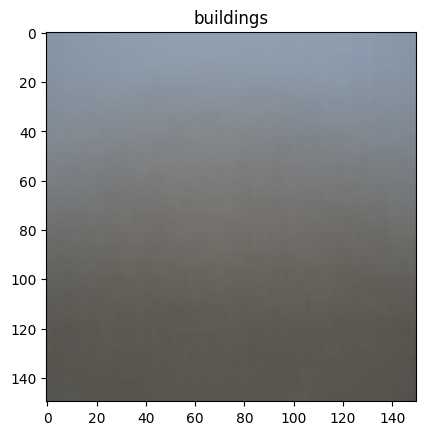

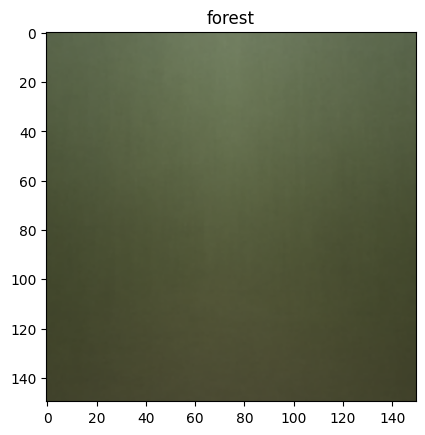

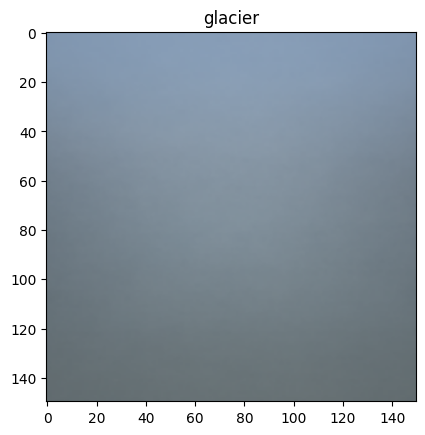

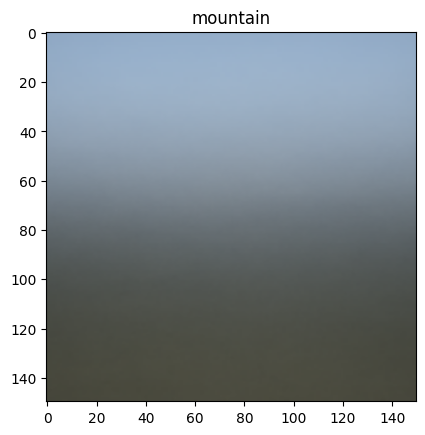

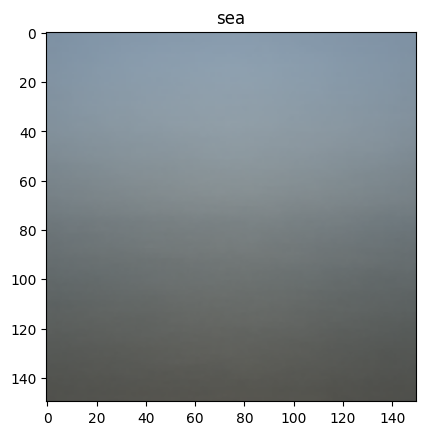

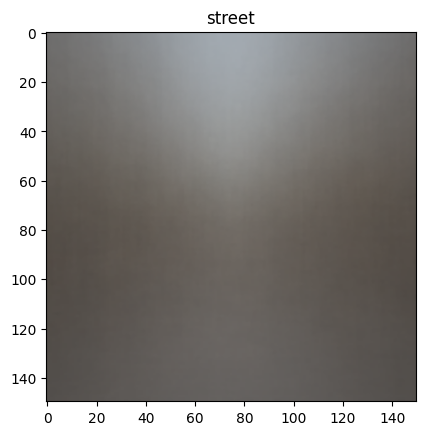

<Figure size 640x480 with 0 Axes>

In [ ]:
centroids = nc_classifier.centroids_

for index, centroid in enumerate(centroids):
  centroid = centroid.reshape((150, 150, 3)).astype(int)
  plt.imshow(centroid)
  plt.title(labels_list[index])
  plt.show()
  plt.savefig(f'/gdrive/My Drive/Kaggle/plots/{index}.png')

In [ ]:
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.metrics import classification_report

mlp_classifier = load('/gdrive/My Drive/Kaggle/classifiers/mlp.joblib')
y_pred_mlp = mlp_classifier.predict(X_test)
print('Multi-layered perceptron')
print(classification_report(y_test, y_pred_mlp))
print()

Multi-layered perceptron
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       437
           1       0.00      0.00      0.00       473
           2       0.00      0.00      0.00       549
           3       0.17      1.00      0.30       523
           4       0.00      0.00      0.00       510
           5       0.00      0.00      0.00       501

    accuracy                           0.17      2993
   macro avg       0.03      0.17      0.05      2993
weighted avg       0.03      0.17      0.05      2993




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
